In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    balanced_accuracy_score,
     roc_curve,
)

c:\Users\devri\anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class_names = [
    "Angioectasia",
    "Bleeding",
    "Erosion",
    "Erythema",
    "Foreign Body",  
    "Lymphangiectasia", 
    "Normal",
    "Polyp",
    "Ulcer",
    "Worms"
]

In [3]:
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]) 

In [4]:
val_dataset = datasets.ImageFolder(root='Dataset\\validation', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
model = timm.create_model("davit_small", pretrained=False, num_classes=10)
model.load_state_dict(torch.load("model_davit_small_wrs_epoch_18.pth"))

C:\Users\devri\AppData\Local\Temp\ipykernel_23532\2291241243.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_davit_small_wrs_epoc

<All keys matched successfully>

In [6]:
model.eval()

DaVit(
  (stem): Stem(
    (conv): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
    (norm): LayerNorm2d((96,), eps=1e-05, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): DaVitStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): Sequential(
          (0): SpatialBlock(
            (cpe1): ConvPosEnc(
              (proj): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
              (act): Identity()
            )
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (cpe2): ConvPosEnc(
              (proj): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
              

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np

In [9]:
all_labels=[]
all_predications=[]
all_probs=[]

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_predications.extend(torch.argmax(outputs, dim=1).cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_predications = np.array(all_predications)

In [10]:
conf_matrix = confusion_matrix(all_labels, all_predications)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  381     6    54     7     1     0    45     3     0     0]
 [    1   315    23     5     0     1     7     7     0     0]
 [   19    27   941    40    18     5    74    20    11     0]
 [    3     6    60   186     3     2    13    24     0     0]
 [    2     0    12     4   313     2     3     4     0     0]
 [    1     1     8     0     1   295    30     7     0     0]
 [    7    10   114    11    17    19 12051    57     1     0]
 [    5     7    34    23     4     6    35   386     0     0]
 [    0     0     0     0     0     0     1     0   282     3]
 [    0     0     0     0     0     0     0     0     0    68]]


In [11]:
class_report = classification_report(all_labels, all_predications)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       497
           1       0.85      0.88      0.86       359
           2       0.76      0.81      0.78      1155
           3       0.67      0.63      0.65       297
           4       0.88      0.92      0.90       340
           5       0.89      0.86      0.88       343
           6       0.98      0.98      0.98     12287
           7       0.76      0.77      0.77       500
           8       0.96      0.99      0.97       286
           9       0.96      1.00      0.98        68

    accuracy                           0.94     16132
   macro avg       0.86      0.86      0.86     16132
weighted avg       0.94      0.94      0.94     16132



In [12]:
balanced_accuracy = balanced_accuracy_score(all_labels, all_predications)
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

Balanced Accuracy: 0.8604


In [13]:
mean_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')  
print(f"Mean AUC: {mean_auc:.4f}")

Mean AUC: 0.9902


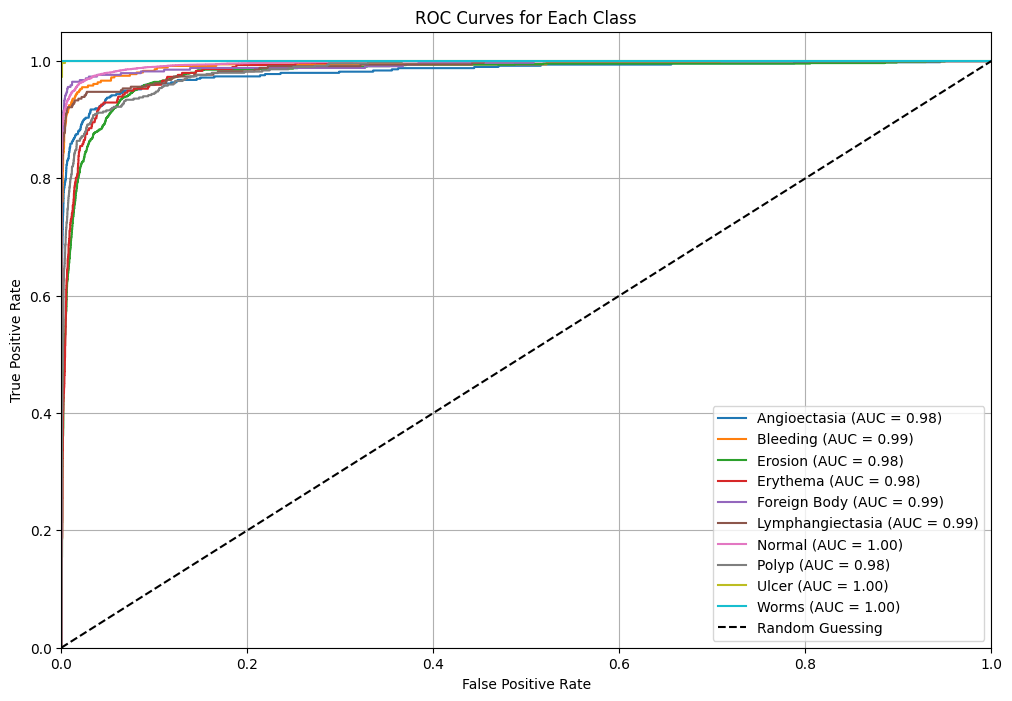

In [14]:
plt.figure(figsize=(12, 8))

for i in range(len(class_names)): 
    
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc_score(all_labels == i, all_probs[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

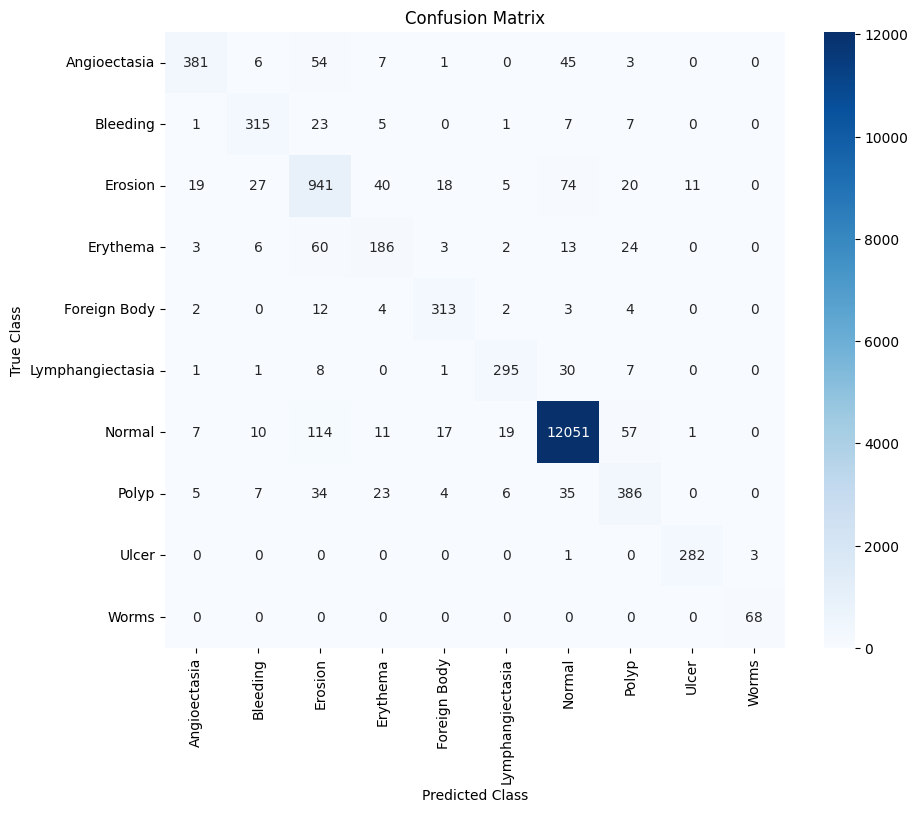

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()